In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import os
from _99_shared_functions import *
import multiprocessing as mp
import matplotlib.pyplot as plt
from scipy import stats as sps
from scipy.stats import beta

pd.options.display.max_rows = 4000
pd.options.display.max_columns = 4000

datadir = f'{os.getcwd()}/data/'
outdir = f'{os.getcwd()}/output/'
figdir = f'{os.getcwd()}/figures/'

# import the census time series and set the zero day to be the first instance of zero
when_to_start = 1
census_ts = pd.read_csv(f"{datadir}census_ts.csv")#.iloc[when_to_start:,:]
# impute vent with the proportion of hosp.  this is a crude hack
census_ts.loc[census_ts.vent.isna(), 'vent'] = census_ts.hosp.loc[census_ts.vent.isna()]*np.mean(census_ts.vent/census_ts.hosp)

nobs = census_ts.shape[0]

# define vent capacity
vent_capacity = 183

idb_obs_non_zero = census_ts.hosp > 0

pos = np.random.uniform(size = params.shape[0])


def loglik(r):
    return -len(r)/2*(np.log(2*np.pi*np.var(r))) - 1/(2*np.pi*np.var(r))*np.sum(r**2)

def eval_pos(pos):
    '''function takes quantiles of the priors and outputs a posterior and relevant stats'''
    draw = SIR_from_params(qdraw(pos))
    
    # loss for vent
    residuals = draw['arr'][when_to_start:nobs,5] - census_ts.vent[when_to_start:] # 5 corresponds with vent census
    if any(residuals == 0):
        residuals[residuals == 0] = 0.001
    LL = loglik(residuals)
    Lprior = np.log(draw['parms'].prob).sum()
    posterior_vent = LL + Lprior
    
    # loss for hosp
    residuals = draw['arr'][when_to_start:nobs,3] - census_ts.hosp[when_to_start:].values # 5 corresponds with vent census
    if any(residuals == 0):
        residuals[residuals == 0] = 0.001
    LL = loglik(residuals)
    Lprior = np.log(draw['parms'].prob).sum()
    posterior_hosp = LL + Lprior
    #average them
    posterior = np.mean([posterior_hosp, posterior_vent]) 
    #posterior = posterior_hosp
    
#     p = draw['arr'][:nobs,3][idb_obs_non_zero] / N
#     x = census_ts.hosp[idb_obs_non_zero].values / N
#     LL = beta.logpdf(x, p*N, (1-p)*N).sum()
#     posterior = LL
    
    out = dict(pos = pos,
               draw = draw,
               posterior = posterior)
    return(out)

def neg_liklihood_only_wrapper(pos):
    if ((pos <= 0).sum() > 0) or ((pos >= 1).sum() > 0):
        return 10e8
    return -eval_pos(pos)['posterior']
    
# list of dictionaries, to put together later
a,b = [], []
jump_sd = .1


def chain(seed):
    np.random.seed(seed)
    current_pos = eval_pos(np.random.uniform(size = params.shape[0]))
    outdicts = []
    preds = []
    for ii in range(1000):
        try:
            proposed_pos = eval_pos(jumper(current_pos['pos'], .1))
            p_accept = np.exp(proposed_pos['posterior']-current_pos['posterior'])
            alpha = np.random.uniform(0,1)
            if alpha < p_accept:
                current_pos = proposed_pos
        
        except Exception as e:
            pass
        # append the relevant results
        out = {current_pos['draw']['parms'].param[i]:current_pos['draw']['parms'].val[i] for i in range(params.shape[0])}
        out.update({"days_until_overacpacity": int(np.apply_along_axis(lambda x: np.where((x - vent_capacity) > 0)[0][0] \
                                                                if max(x) > vent_capacity else -9999, axis=0,
                                                                arr=current_pos['draw']['arr'][:,5]))})
        out.update({"peak_demand":np.max(current_pos['draw']['arr'][:,5])})
        out.update({"arr": current_pos['draw']['arr']})
        out.update({"iter":ii})
        out.update({"chain":seed})
        out.update({'posterior':proposed_pos['posterior']})
        outdicts.append(out)
        preds.append(current_pos['draw']['arr'])
    return pd.DataFrame(outdicts), preds

In [3]:
start_qs = np.array([0.5 for p in range(params.shape[0])])

In [4]:
eval_pos(start_qs)['draw']['parms']

,param,val,prob
0,n_hosp,2.000000e+00,1.000000
1,n_infec,5.140000e+02,1.000000
2,doubling_time,2.906090e+00,0.451295
3,soc_dist,0.000000e+00,1.000000
4,hosp_prop,2.500000e-02,39.262148
5,ICU_prop,5.000000e-01,2.710844
6,vent_prop,6.399999e-01,2.327140
7,hosp_LOS,1.188803e+01,0.391264
8,ICU_LOS,8.655852e+00,0.261506
9,vent_LOS,1.081982e+00,2.092051


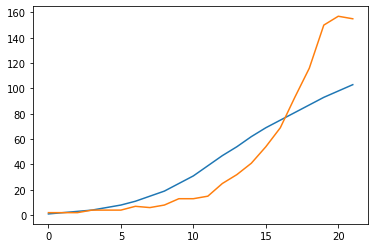

In [5]:
draw = eval_pos(start_qs)['draw']
plt.plot(draw['arr'][when_to_start:nobs,3])
plt.plot(census_ts.hosp[when_to_start:].values)

In [6]:
eval_pos(start_qs)['posterior']

-85.66581346424591

Optimization terminated successfully.
         Current function value: 57.465619
         Iterations: 655
         Function evaluations: 1065


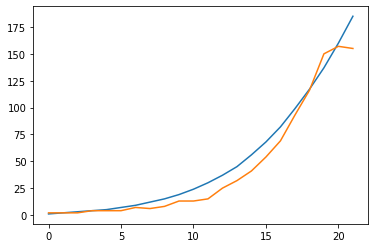

In [7]:
from scipy.optimize import fmin

def neg_liklihood_only_wrapper(pos):
    if ((pos <= 0).sum() > 0) or ((pos >= 1).sum() > 0):
        return 10e8
    return -eval_pos(pos)['posterior']

current_pos = eval_pos(start_qs)
fit = fmin(neg_liklihood_only_wrapper, start_qs)

draw = eval_pos(fit)['draw']
plt.plot(draw['arr'][when_to_start:nobs,3])
plt.plot(census_ts.hosp[when_to_start:].values)

(0.2708629790387607, 0.7281754583479647, 16.91274252646677)

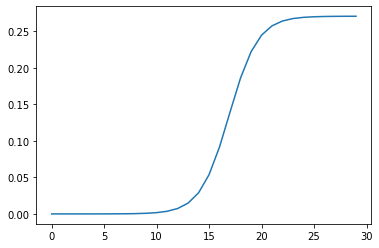

In [8]:
logistic_x0 = draw['parms'].loc[draw['parms']['param'] =='logistic_x0', 'val'].values[0]
logistic_k = draw['parms'].loc[draw['parms']['param'] =='logistic_k', 'val'].values[0]
logistic_L = draw['parms'].loc[draw['parms']['param'] =='logistic_L', 'val'].values[0]


days = range(30)
logis = [logistic(logistic_L, logistic_k, logistic_x0, x = d) for d in days]
plt.plot(days, logis)
logistic_L, logistic_k, logistic_x0

In [9]:
draw['parms']

,param,val,prob
0,n_hosp,2.000000e+00,1.000000
1,n_infec,5.140000e+02,1.000000
2,doubling_time,3.229889e+00,0.395180
3,soc_dist,0.000000e+00,1.000000
4,hosp_prop,2.564319e-02,38.524369
5,ICU_prop,5.579027e-01,2.533325
6,vent_prop,6.655931e-01,2.355981
7,hosp_LOS,1.161115e+01,0.382856
8,ICU_LOS,8.255212e+00,0.260488
9,vent_LOS,1.055495e+00,2.106218


In [10]:
1.807399e+01

18.07399

In [11]:
residuals = draw['arr'][when_to_start:nobs,3] - census_ts.hosp[when_to_start:].values
residuals

array([ -1.,   0.,   1.,   0.,   1.,   3.,   2.,   6.,   7.,   6.,  11.,
        15.,  12.,  13.,  15.,  14.,  13.,   6.,   1., -13.,   3.,  30.])

In [12]:
if any(residuals == 0):
    residuals[residuals == 0] = 1

In [13]:
residuals**2

array([  1.,   1.,   1.,   1.,   1.,   9.,   4.,  36.,  49.,  36., 121.,
       225., 144., 169., 225., 196., 169.,  36.,   1., 169.,   9., 900.])

In [14]:
LL = np.sum(-(residuals**2))

In [15]:
LL

-2503.0

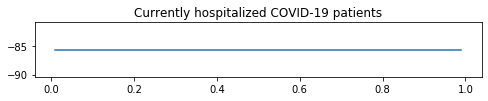

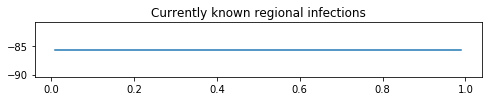

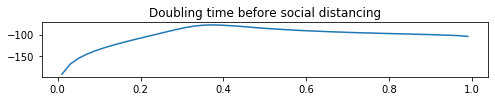

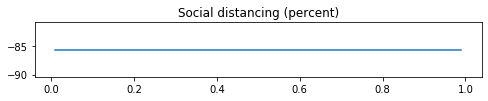

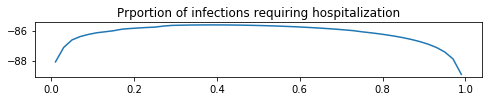

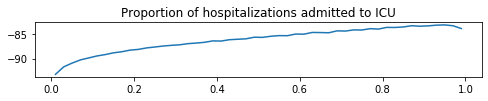

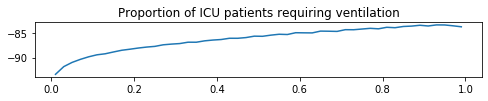

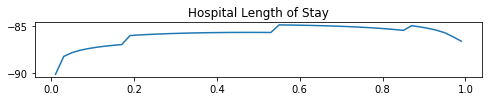

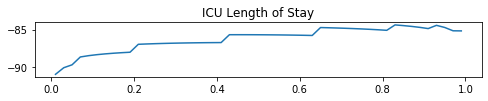

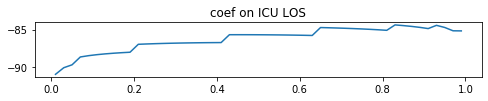

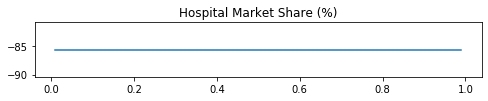

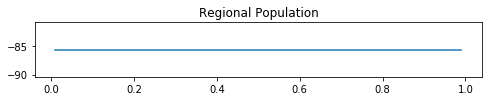

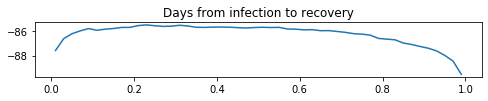

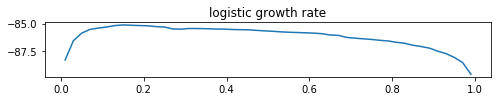

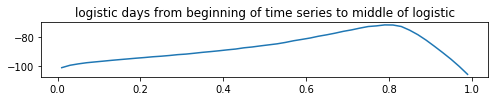

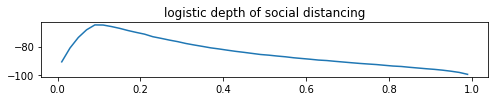

In [16]:
var_i = 1
for var_i in range(params.shape[0]):
    p_space = np.linspace(0.01,0.99)
    ll = np.zeros(p_space.shape[0])
    for i, p_val in enumerate(p_space):
        sq  = np.array([0.5 for p in range(params.shape[0])])
        sq[var_i] = p_val
        try:
            eval_ = eval_pos(sq)
            ll[i] = eval_['posterior']
        except:
            ll[i] = np.nan
    fig, ax = plt.subplots(1,1, figsize=(8,1))
    ax.plot(p_space, ll)
    ax.set_title(params['description'].values[var_i])
    plt.show()

In [17]:
params

,Unnamed: 0,X.1,X,param,base,distribution,p1,p2,description
0,1,1,1,n_hosp,2.000000e+00,constant,NaN,NaN,Currently hospitalized COVID-19 patients
1,2,2,2,n_infec,5.140000e+02,constant,NaN,NaN,Currently known regional infections
2,3,3,3,doubling_time,2.750000e+00,gamma,11.082593,0.270306,Doubling time before social distancing
3,4,4,4,soc_dist,0.000000e+00,constant,0.000000,0.700000,Social distancing (percent)
4,5,5,5,hosp_prop,2.500000e-02,gamma,6.326833,0.004169,Prportion of infections requiring hospitalization
5,6,6,6,ICU_prop,4.500000e-01,beta,6.016241,6.016241,Proportion of hospitalizations admitted to ICU
6,7,7,7,vent_prop,6.600000e-01,beta,5.224029,3.078885,Proportion of ICU patients requiring ventilation
7,8,8,8,hosp_LOS,1.200000e+01,gamma,136.214801,0.087488,Hospital Length of Stay
8,9,9,9,ICU_LOS,9.000000e+00,gamma,32.470137,0.269339,ICU Length of Stay
9,10,10,10,vent_LOS,1.111111e+00,gamma,32.470136,0.033667,coef on ICU LOS


In [18]:
draw = current_pos['draw']

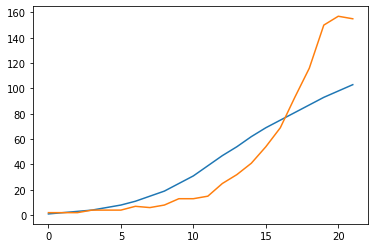

In [19]:
plt.plot(draw['arr'][when_to_start:nobs,3])
plt.plot(census_ts.hosp[when_to_start:].values)

In [20]:
df, preds = chain(123)

/Users/cchivers/anaconda2/envs/hypertensionbot/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


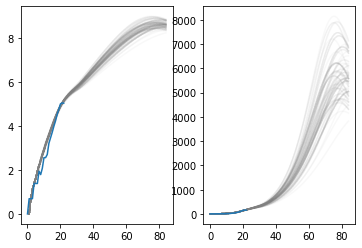

In [25]:
obs = census_ts.hosp.values
fig, ax = plt.subplots(1,2)
preds_end = preds[-500:]
n_days_to_plot = 85
for i in np.random.choice(range(len(preds_end)), 100):
    pred = preds_end[i]
    ax[0].plot(np.log(pred[:n_days_to_plot,3]), alpha=0.05,color='grey')
    ax[1].plot(pred[:n_days_to_plot,3], alpha=0.05,color='grey')

ax[0].plot(np.log(obs))
ax[1].plot(obs)
#ax.set_ylim(min(np.log(obs))*1.1,max(np.log(obs))*1.1)

/Users/cchivers/anaconda2/envs/hypertensionbot/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


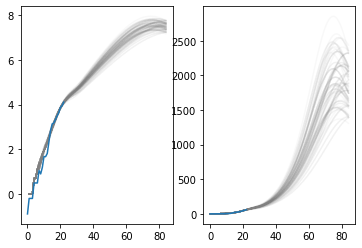

In [26]:
obs = census_ts.vent.values
fig, ax = plt.subplots(1,2)
preds_end = preds[-500:]
for i in np.random.choice(range(len(preds_end)), 100):
    pred = preds_end[i]
    ax[0].plot(np.log(pred[:n_days_to_plot,5]), alpha=0.05,color='grey')
    ax[1].plot(pred[:n_days_to_plot,5], alpha=0.05,color='grey')

ax[0].plot(np.log(obs))
ax[1].plot(obs)
#ax.set_ylim(min(np.log(obs))*1.1,max(np.log(obs))*1.1)

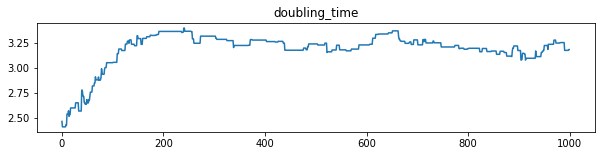

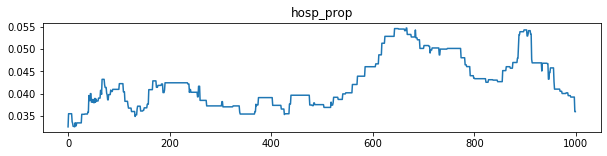

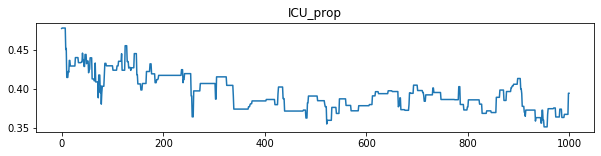

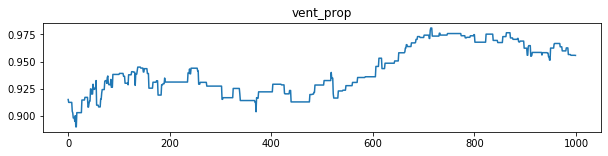

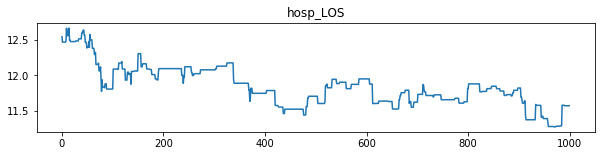

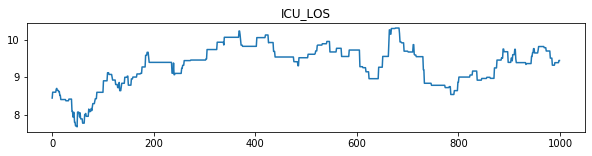

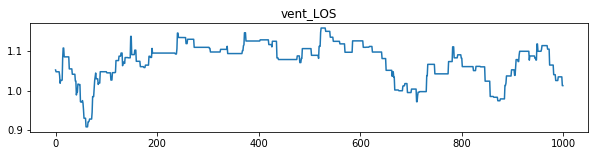

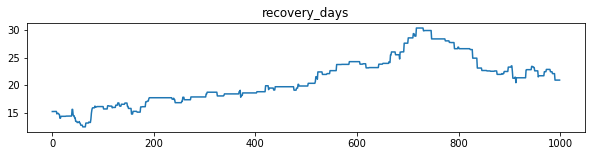

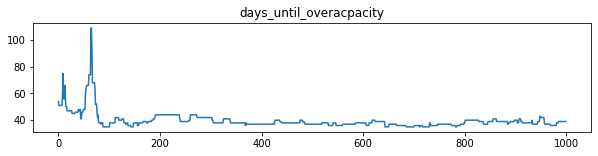

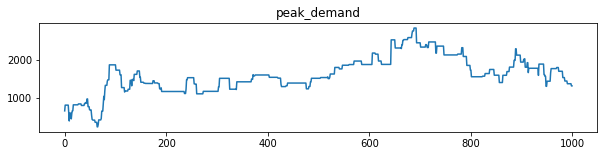

In [23]:
cols_to_plot = [
 'doubling_time',
 #'soc_dist',
 'hosp_prop',
 'ICU_prop',
 'vent_prop',
 'hosp_LOS',
 'ICU_LOS',
 'vent_LOS',
 'recovery_days',
 'days_until_overacpacity',
 'peak_demand']

for c in cols_to_plot:
    fig, ax = plt.subplots(1,1,figsize=(10,2))
    ax.plot(df[c])
    ax.set_title(c)
    plt.show()